In [1]:
# %load_ext autoreload
# %autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import sys
sys.path.append('../')

from matplotlib.colors import LogNorm
from src.viz import plot_trajectories, use_mpl_scatter_density, plot_transition_matrix,plot_implied_timescales
from src.io import load_dataframe, save_dataframe
from src.preprocessing import (compute_phases,split_trajectories,filter_trajectories,smooth_trajectory_savgol)
from src.embedding import Embedding
from src.embedding_position import EmbeddingPosition
from umap import UMAP
from src.preprocessing import reconstruct_trajectory_from_angles

from scipy.spatial import Voronoi, voronoi_plot_2d


In [2]:
df = pd.read_parquet('../data/toy_model/interim/phases.parquet')
df.head()

,x,y,z,label,frame,speed,curvature_angle,torsion_angle,abs_torsion_angle
0,2.971357,-0.492802,0.017792,1,1,0.525221,0.094435,-0.244909,0.244909
1,2.876396,-0.950373,-0.036095,1,2,0.466730,0.255589,-0.684180,0.684180
2,2.672222,-1.361130,-0.099340,1,3,0.494689,0.138352,1.028470,1.028470
3,2.386681,-1.802276,-0.129122,1,4,0.532629,0.217697,-0.228356,0.228356
4,2.012757,-2.182973,-0.204540,1,5,0.517192,0.085735,-0.092336,0.092336


/mnt/hcleroy/anaconda3/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/mnt/hcleroy/anaconda3/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


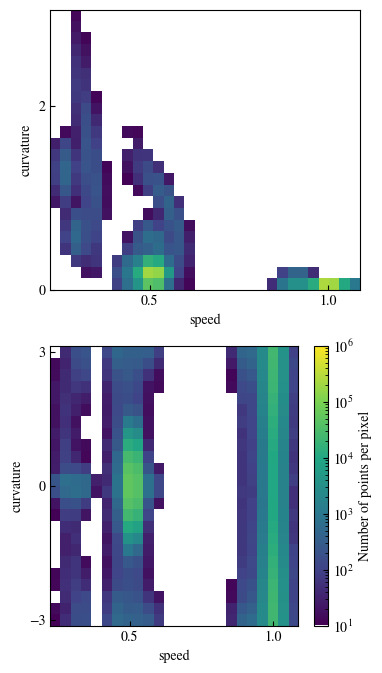

In [3]:
#plt.scatter(df[df['label'] ==1]['speed'],df[df['label'] ==1]['curvature_angle'],marker='o',alpha=0.1)
fig = plt.figure(figsize=(4,8))
norm = LogNorm(vmin=1e1,vmax=10**6)
ax1 = use_mpl_scatter_density(fig, df['speed'],df['curvature_angle'],dpi=10,norm=norm,nrows=2,pos=1,colorbar=None)
ax1.set_xlabel('speed')
ax1.set_ylabel('curvature')
ax1.set_xticks([0.5,1.])
ax1.set_yticks([0.,2.])
#ax1.grid()
ax2 = use_mpl_scatter_density(fig, df['speed'],df['torsion_angle'],dpi=10,norm=norm,nrows=2,pos=2)
ax2.set_xlabel('speed')
ax2.set_ylabel('curvature')
ax2.set_xticks([0.5,1])
ax2.set_yticks([-3,0,3])
#ax2.grid()
#fig.savefig('phase_space_toy_model.svg',transparent=True,bbox_inches='tight')

In [4]:
#emb = Embedding(df,
#                columns=['speed','curvature_angle','torsion_angle'],
#                ID_NAME='label')
emb = EmbeddingPosition(df,columns=[],columns_translated=['x','y','z'],ID_NAME='label')
#emb = Embedding(df,
#                columns=['speed','curvature_angle'],ID_NAME='label')

In [21]:
emb.make_embedding(K=5)
emb.make_cluster(5,clustering_method='kmeans')#,n_subsample=1000)

array([0, 0, 1, ..., 2, 2, 2], dtype=int32)

In [22]:
# Label the rest by nearest center
from scipy.spatial.distance import cdist
dists = cdist(emb.flatten_embedding_matrix, emb.cluster_centers_, metric='euclidean')
emb.labels = np.argmin(dists, axis=1)
#self.cluster_centers_ = centers
#return self.labels

1
1


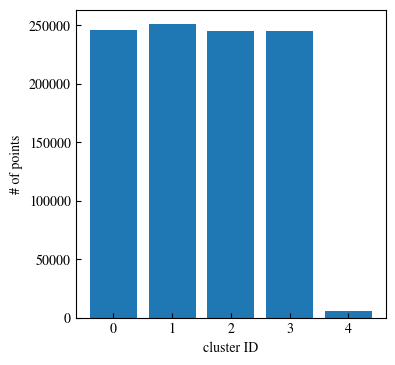

In [23]:
# look at the distribution of points in the clusters
unique_labels, counts = np.unique(emb.labels, return_counts=True)
# Optionally, zip into a dict
cluster_counts = dict(zip(unique_labels, counts))
fig,ax = plt.subplots(figsize=(4,4))
ax.bar(list(cluster_counts.keys()),list(cluster_counts.values()))
ax.set_xlabel('cluster ID')
ax.set_ylabel('# of points')
print(unique_labels[np.argmax(counts)])
print(np.argmax(counts))

In [24]:
rng = np.random.default_rng(10973)
indices = rng.choice(emb.flatten_embedding_matrix.shape[0], size=10000, replace=False)
data = emb.flatten_embedding_matrix[indices]
    
combined =np.array([])
# Concatenate data and centers before UMAP
combined = np.append(data, emb.cluster_centers_, axis=0)

In [25]:
reducer = UMAP(
        n_neighbors=10,
        min_dist=0.5,
        n_components=2,
        metric="euclidean",
    )
reduced_all = reducer.fit_transform(combined)

In [26]:
N = data.shape[0]
reduced_points = reduced_all[:N]
reduced_centers = reduced_all[N:N + emb.cluster_centers_.shape[0]]

(10000,)


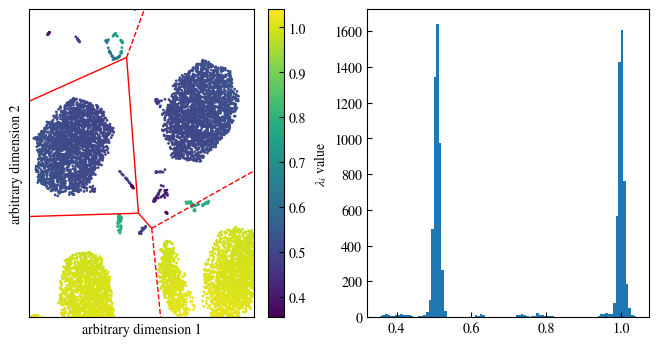

In [27]:
fig,ax = plt.subplots(ncols=2,figsize=(8,4))

speedx = emb.flatten_embedding_matrix[indices,0::3][:,1:] - emb.flatten_embedding_matrix[indices,0::3][:,:-1]
speedy = emb.flatten_embedding_matrix[indices,1::3][:,1:] - emb.flatten_embedding_matrix[indices,1::3][:,:-1]
speedz = emb.flatten_embedding_matrix[indices,2::3][:,1:] - emb.flatten_embedding_matrix[indices,2::3][:,:-1]
speed = np.mean(np.linalg.norm(np.array([speedx,speedy,speedz]).T,axis=2),axis=0)
print(speed.shape)
color_values = speed#np.mean(emb.flatten_embedding_matrix[indices, 0::3], axis=1)
sc = ax[0].scatter(reduced_points[:,0],reduced_points[:,1],c = color_values,s=1.,alpha=1,rasterized=True)
#ax = use_mpl_scatter_density(fig, reduced_points[:,0],reduced_points[:,1],dpi=10,nrows=1,pos=1,colorbar=None)
#for i in range(reduced_centers.shape[0]):
#    ax.scatter(reduced_centers[i,0],reduced_centers[i,1],s=counts[i]*0.01,color="red", alpha=0.3)
    
vor = Voronoi(reduced_centers)
voronoi_plot_2d(vor, ax=ax[0], show_points = False, show_vertices=False, line_colors='red')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel('arbitrary dimension 1')
ax[0].set_ylabel('arbitrary dimension 2')
#fig.savefig('umap1.svg',transparent=True,bbox_inches='tight')
ax[1].hist(speed,bins=100)

cbar = fig.colorbar(sc, ax=ax[0])
cbar.set_label(r'$\lambda_i$ value')
#cbar.ax.set_yticks([])  

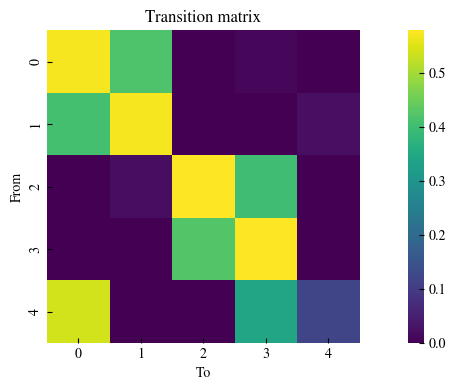

In [28]:
emb.make_transition_matrix(tau=1)
fig, axs = plt.subplots(1, 1, figsize=(10, 4))
plot_transition_matrix(emb.P, ax=axs)
#plot_distribution(emb.pi, ax=axs[1])
plt.tight_layout()
#plt.savefig('transition_matrix.svg',transparent=True,bbox_inches='tight')

Text(0, 0.5, 'amplitude of $v_2$')

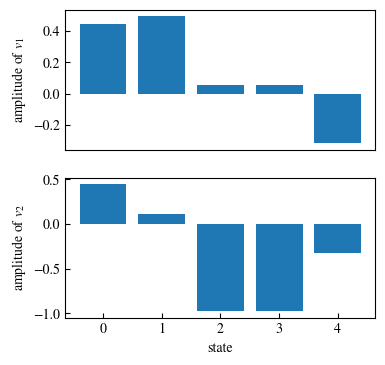

In [29]:
fig,ax = plt.subplots(figsize=(4,4),nrows=2)
# find the spectrum of the stochastic matrix
eig_val,eig_vec = np.linalg.eig(emb.P)
real_spectrum = np.real(eig_val)
# sort the eigen system according to the value of the real part
eig_vec = eig_vec[np.argsort(real_spectrum)]
real_spectrum = real_spectrum[np.argsort(real_spectrum)]
slow_mode = np.real(eig_vec[-2])
ax[0].bar(np.arange(0,slow_mode.shape[0],1),slow_mode)
ax[0].set_xticks([])
slow_mode = np.real(eig_vec[-3])
ax[1].bar(np.arange(0,slow_mode.shape[0],1),slow_mode)
ax[1].set_xlabel('state')
ax[0].set_ylabel(r'amplitude of $v_1$')
ax[1].set_ylabel(r'amplitude of $v_2$')
#fig.savefig('first_two_eigen_vect.svg',bbox_inches='tight')

[]

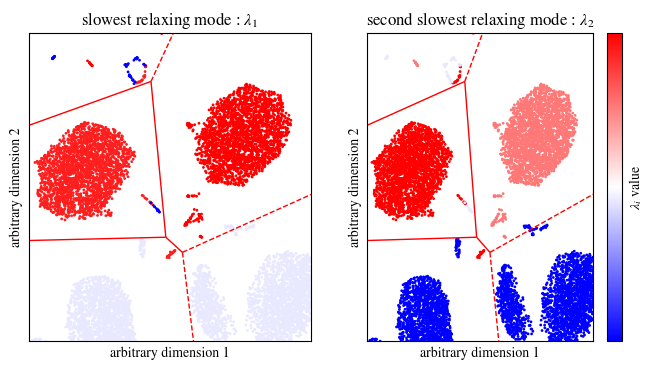

In [30]:
fig,ax = plt.subplots(ncols=2,figsize=(8,4))
slow_mode = np.real(eig_vec[-2])
color_values = [slow_mode[lab] for lab in emb.labels[indices]]
ax[0].scatter(reduced_points[:,0],reduced_points[:,1],c = color_values,s=1.,alpha=1.,rasterized=True,cmap='bwr')
#ax = use_mpl_scatter_density(fig, reduced_points[:,0],reduced_points[:,1],dpi=10,nrows=1,pos=1,colorbar=None)
#for i in range(reduced_centers.shape[0]):
#    ax.scatter(reduced_centers[i,0],reduced_centers[i,1],s=counts[i]*0.01,color="red", alpha=0.3)
    
vor = Voronoi(reduced_centers)
voronoi_plot_2d(vor, ax=ax[0], show_points = False, show_vertices=False, line_colors='red')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel('arbitrary dimension 1')
ax[0].set_ylabel('arbitrary dimension 2')
ax[0].set_title(r'slowest relaxing mode : $\lambda_1$')

slow_mode = np.real(eig_vec[-3])
color_values = [slow_mode[lab] for lab in emb.labels[indices]]
sc = ax[1].scatter(reduced_points[:,0],reduced_points[:,1],c = color_values,s=1.,alpha=1.,rasterized=True,cmap='bwr')
    
vor = Voronoi(reduced_centers)
voronoi_plot_2d(vor, ax=ax[1], show_points = False, show_vertices=False, line_colors='red')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel('arbitrary dimension 1')
ax[1].set_ylabel('arbitrary dimension 2')
ax[1].set_title(r'second slowest relaxing mode : $\lambda_2$')

cbar = fig.colorbar(sc, ax=ax[1])
cbar.set_label(r'$\lambda_i$ value')
cbar.ax.set_yticks([])  
#fig.savefig('umap_color_lambda.svg',transparent=True,bbox_inches='tight')

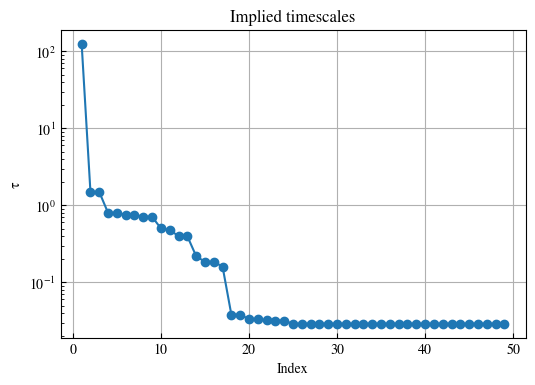

In [20]:
ts = emb.implied_timescales(emb.P, lag=emb.tau)

fig, ax = plt.subplots(figsize=(6, 4))
plot_implied_timescales(ts, ax=ax)
plt.yscale('log')

In [19]:
emb.make_transition_matrix(tau=1)
state_trajectory = list()
emb.initialize_state()
state_trajectory.append(emb.state)
for i in range(50):
    emb.make_transition()
    state_trajectory.append(emb.state)
state_trajectory=np.array(state_trajectory)

In [431]:
phase_trajectory = list()
for points in state_trajectory:
    phase_trajectory.append(emb.pick_random_trajectory_in_cluster(points))
phase_trajectory = np.array(phase_trajectory)

In [432]:
speed, theta,torsion = phase_trajectory.flatten()[0::3],phase_trajectory.flatten()[1::3],phase_trajectory.flatten()[2::3]
traj = reconstruct_trajectory_from_angles(np.array([speed,theta,torsion]).T)
#speed, theta,torsion = phase_trajectory.flatten()[0::2],phase_trajectory.flatten()[1::2]
#traj = reconstruct_trajectory_from_angles(np.array([speed,theta]).T)

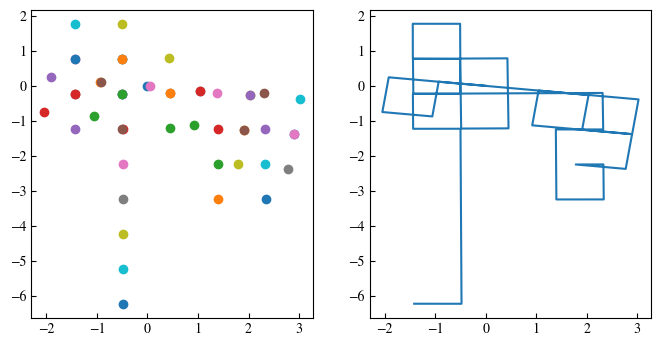

In [433]:
fig,ax = plt.subplots(ncols=2,figsize=(8,4))
tint = phase_trajectory.shape[1]//2 # phase_trajectory.shape[1] contains x and y
for i in range(phase_trajectory.shape[0]):
    ax[0].plot(traj[i*tint:(i+1)*tint,0],traj[i*tint:(i+1)*tint,1],marker='o')
ax[1].plot(traj[:,0],traj[:,1])

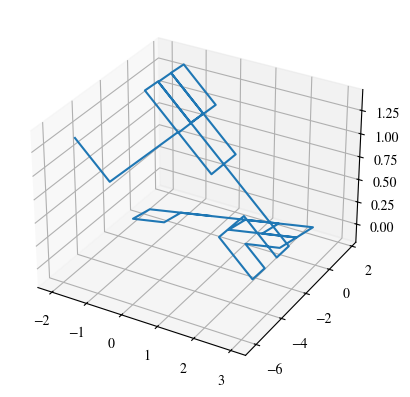

In [434]:
ax = plt.subplot(projection='3d')
ax.plot(traj[:,0],traj[:,1],traj[:,2])

In [335]:
df1 = pd.read_csv('../data/toy_model/interim/longest_trajectory.csv')
df1.head()

,x,y,z,label,frame,speed,curvature_angle,torsion_angle,abs_torsion_angle
0,2.929049,1.132753,0.139303,0,1,1.047904,0.393285,0.067051,0.067051
1,2.365123,1.951153,0.265286,0,2,1.003702,0.275906,-0.398100,0.398100
2,1.607666,2.584064,0.457275,0,3,1.008354,0.300475,-0.030763,0.030763
3,0.683506,2.972553,0.589183,0,4,1.012413,0.357366,0.422935,0.422935
4,-0.328206,3.025995,0.623126,0,5,1.004846,0.398219,0.186152,0.186152


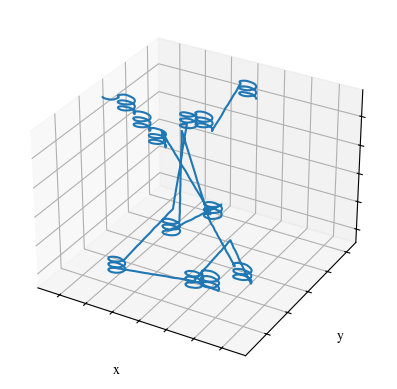

In [444]:
ax = plt.subplot(projection='3d')
ax.plot(df1['x'],df1['y'],df1['z'])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.grid(True)
plt.savefig('toy_trajectory.svg',transparent=True,bbox_inches='tight')
